In [ ]:
from google.colab import drive
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Yêu cầu quyền truy cập vào Google Drive
drive.mount('/content/drive', force_remount=True)

# Đường dẫn thư mục project
project_dir = '/content/drive/My Drive/Project II/'

# Kiểm tra xem project_dir có tồn tại không trước khi thay đổi thư mục làm việc
if os.path.exists(project_dir):
    os.chdir(project_dir)
    print("Nội dung trong thư mục:")
    print(os.listdir())  # Liệt kê nội dung thư mục
else:
    print(f"Thư mục không tồn tại: {project_dir}")

Mounted at /content/drive
Nội dung trong thư mục:
['results', 'preprocess', 'data', 'models']


# **1. Khai báo thư viện**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.modules.loss import _Loss

import scipy.sparse as sp
import random
from scipy.special import expit
from tqdm import tqdm
from collections import defaultdict

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === MF ===
model_dir = '/content/drive/My Drive/Project II/models/ckpt/mf_bpr_full_corpus.pth'

# **2. Load và chia dữ liệu**

## **2.1. Chia dữ liệu theo chiến lược Full-Corpus**

In [ ]:
# Load dữ liệu
data_dir = project_dir + "data/"
dataset = pd.read_csv(data_dir + "recommendations_processed.csv").copy()  # Thêm .copy() để tạo bản sao rõ ràng

# Explicitly convert 'date' column to datetime objects
dataset['date'] = pd.to_datetime(dataset['date'])

# Loại trừ duplicate
dataset = dataset.sort_values("date")  # Sort theo thời gian
dataset = dataset.drop_duplicates(subset=['user_id', 'app_id'], keep='last')

# Mapping user_id, game_id sang user_index, game_index
all_user_ids = dataset['user_id'].unique()
all_game_ids = dataset['app_id'].unique()

user_id_mapping = {user_id: idx for idx, user_id in enumerate(sorted(all_user_ids))}
game_id_mapping = {item_id: idx for idx, item_id in enumerate(sorted(all_game_ids))}

# Cập nhật lại user_id, app_id sử dụng .loc
dataset.loc[:, 'user_id'] = dataset['user_id'].map(user_id_mapping)
dataset.loc[:, 'app_id'] = dataset['app_id'].map(game_id_mapping)

In [ ]:
def split_data_full_corpus(df, ratio=0.918):
    # Với tỉ lệ thời gian 0.918 thì sẽ ra được tỉ lệ số lượng ~80%
    df = df.sort_values("date")
    start_date = df["date"].min()
    end_date = df["date"].max()
    pivot_date = start_date + (end_date - start_date) * ratio
    train_set = df[df["date"] < pivot_date].copy()
    test_set = df[df["date"] >= pivot_date].copy()
    return train_set, test_set

# Chia dữ liệu theo chiến lược full corpus
train_df, test_df = split_data_full_corpus(dataset)
train_df, valid_df = split_data_full_corpus(train_df)

print(f"train_df: {train_df.shape}")
print(f"valid_df: {valid_df.shape}")
print(f"test_df: {test_df.shape}")

train_df: (1571114, 8)
valid_df: (486039, 8)
test_df: (477880, 8)


## **2.2. Thống kê đơn giản**

In [ ]:
# Số lượng users, games
num_users = len(all_user_ids)
num_games = len(all_game_ids)

print(f"Số lượng users: {num_users}")
print(f"Số lượng games: {num_games}")

# Print cold-start statistics
train_users = set(train_df['user_id'].unique())
train_items = set(train_df['app_id'].unique())

valid_users = set(valid_df['user_id'].unique())
valid_items = set(valid_df['app_id'].unique())

test_users = set(test_df['user_id'].unique())
test_items = set(test_df['app_id'].unique())

valid_cold_start_users = valid_users - train_users
valid_cold_start_items = valid_items - train_items
test_cold_start_users = test_users - train_users
test_cold_start_items = test_items - train_items

print("\n=== Cold-start analysis in valid ===")
print(f"Total users in valid: {len(valid_users)}")
print(f"--> Cold-start users in valid: {len(valid_cold_start_users)}")
print(f"Total items in valid: {len(valid_items)}")
print(f"--> Cold-start games in valid: {len(valid_cold_start_items)}")

print("\n=== Cold-start analysis in test ===")
print(f"Total users in test: {len(test_users)}")
print(f"--> Cold-start users in test: {len(test_cold_start_users)}")
print(f"Total items in test: {len(test_items)}")
print(f"--> Cold-start games in test: {len(test_cold_start_items)}")

Số lượng users: 47274
Số lượng games: 4632

=== Cold-start analysis in valid ===
Total users in valid: 45039
--> Cold-start users in valid: 903
Total items in valid: 4121
--> Cold-start games in valid: 524

=== Cold-start analysis in test ===
Total users in test: 47274
--> Cold-start users in test: 903
Total items in test: 4609
--> Cold-start games in test: 1029


# **3. Các hàm tiện ích**

## **3.1. Các lớp bao dữ liệu**

In [ ]:
class Data:
    def __init__(self, pos_users, pos_items, all_neg_items, user_to_idx):
        self.pos_users = pos_users
        self.pos_items = pos_items
        self.all_neg_items = all_neg_items
        self.user_to_idx = user_to_idx

class FullCorpusData:
    def __init__(self, labels, has_interacted_masks, valid_users, warm_item_mask):
        self.labels = labels  # Ground truth labels [num_users, num_games]
        self.has_interacted_masks = has_interacted_masks  # Boolean mask of interactions [num_users, num_games]
        self.valid_users = valid_users  # Tensor of user IDs
        self.warm_item_mask = warm_item_mask  # Boolean mask of warm items [num_games]

class TestData:
    def __init__(self, labels: torch.Tensor, has_interacted_masks: torch.Tensor,
                 user_ids: torch.Tensor, warm_items_mask: torch.Tensor,
                 warm_users_mask: torch.Tensor):
        self.labels = labels  # Ground truth labels [num_users, num_games]
        self.has_interacted_masks = has_interacted_masks  # Boolean mask of interactions [num_users, num_games]
        self.user_ids = user_ids  # Tensor of user IDs
        self.warm_items_mask = warm_items_mask  # Boolean mask of warm items [num_games]
        self.warm_users_mask = warm_users_mask  # Boolean mask of warm users [num_users]

## **3.2. Hàm tạo ma trận tương tác user-item**

In [ ]:
def create_interact_matrix(dataset: pd.DataFrame, num_users: int, num_items: int) -> torch.BoolTensor:
    # Chỉ lấy các tương tác positive trên toàn bộ dataset
    pos_df = dataset[dataset['is_recommended'] == 1]
    rows = pos_df['user_id'].to_numpy()
    cols = pos_df['app_id'].to_numpy()
    data = np.ones_like(rows, dtype=np.bool_)
    mat = sp.coo_matrix((data, (rows, cols)), shape=(num_users, num_items))
    return torch.from_numpy(mat.toarray())  # dtype=bool mặc định

full_matrix = create_interact_matrix(dataset, num_users, num_games)
train_matrix = create_interact_matrix(train_df, num_users, num_games)
valid_matrix = create_interact_matrix(valid_df, num_users, num_games)

## **3.1. Hàm định nghĩa Ranking Metrics**

In [ ]:
def precision_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> torch.Tensor:
    topk = torch.topk(scores, k, dim=1).indices
    hits = torch.gather(labels, 1, topk)
    return hits.sum(dim=1) / k

def recall_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> torch.Tensor:
    topk = torch.topk(scores, k, dim=1).indices
    hits = torch.gather(labels, 1, topk)
    relevant = labels.sum(dim=1).clamp(min=1e-8)  # avoid divide by zero
    return hits.sum(dim=1) / relevant

def ndcg_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> torch.Tensor:
    device = scores.device
    topk = torch.topk(scores, k, dim=1).indices
    hits = torch.gather(labels, 1, topk)

    weights = torch.log2(torch.arange(2, k + 2, device=device).float())
    dcg = (hits / weights).sum(dim=1)

    ideal_len = labels.sum(dim=1).clamp(max=k).long()
    idcg = torch.stack([
        (1.0 / weights[:L]).sum() if L > 0 else torch.tensor(0.0, device=device)
        for L in ideal_len
    ])
    return dcg / idcg.clamp(min=1e-8)

def hitrate_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> torch.Tensor:
    topk = torch.topk(scores, k, dim=1).indices
    hits = torch.gather(labels, 1, topk)
    return (hits.sum(dim=1) > 0).float()

## **3.2 Hàm mất mát BPR**

In [ ]:
class BPRLoss(_Loss):
    def __init__(self, lambda_reg: float = 1e-3):
        super().__init__()
        self.lambda_reg = lambda_reg

    def forward(self,
                pos_score: torch.Tensor,
                neg_score: torch.Tensor,
                parameters: torch.Tensor = None) -> torch.Tensor:
        if pos_score.dim() == 1:
            pos_score = pos_score.unsqueeze(1)  # [batch_size, 1]

        log_prob = F.logsigmoid(pos_score - neg_score).mean()

        regularization = 0
        if self.lambda_reg != 0 and parameters is not None:
            regularization = self.lambda_reg * parameters.norm(p=2).pow(2)
            regularization = regularization / pos_score.size(0)

        return -log_prob + regularization

# **4. Định nghĩa mô hình MF-BPR**

In [ ]:
class MF_BPR(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim):
        super(MF_BPR, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

        # User embedding, Item embedding
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        self.reset_parameters()

    def reset_parameters(self):
        # nn.init.xavier_normal_(self.user_embedding.weight)
        # nn.init.xavier_normal_(self.item_embedding.weight)
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)

    def forward(self, user_ids: torch.Tensor, item_ids: torch.Tensor) -> torch.Tensor:
        # Get embeddings
        user_emb = self.user_embedding(user_ids)  # [batch_size, embedding_dim]
        item_emb = self.item_embedding(item_ids)  # [batch_size, embedding_dim]

        # Compute interaction
        scores = (user_emb * item_emb).sum(dim=1)  # [batch_size]
        return scores

    def compute_bpr_loss(self,
                         pos_scores: torch.Tensor,
                         neg_scores: torch.Tensor,
                         lambda_reg: float = 1e-3) -> torch.Tensor:
        loss_fn = BPRLoss(lambda_reg=lambda_reg)

        # Collect all learnable parameters
        all_params = []
        for param in self.parameters():
            if param.requires_grad:
                all_params.append(param.view(-1))

        concatenated_params = torch.cat(all_params) if all_params else None
        return loss_fn(pos_scores, neg_scores, concatenated_params)

# **5. Huấn luyện mô hình**

## **5.1. Định nghĩa hàm train**

In [ ]:
def train(model, train_data, train_loader, scheduler, optimizer, device, lambda_reg=1e-3, criterion='bpr', num_neg=3):
    model.train()
    total_loss = 0.0
    total_examples = 0

    num_users = model.num_users
    num_items = model.num_items

    pos_users = train_data.pos_users.to(device)
    pos_items = train_data.pos_items.to(device)
    all_neg_items = train_data.all_neg_items.to(device)
    user_to_train_idx = train_data.user_to_idx

    for batch_index in tqdm(train_loader, desc="Training", leave=False):
        # === Positive Samples ===
        batch_pos_users = pos_users[batch_index]
        batch_pos_items = pos_items[batch_index]
        batch_size = batch_pos_users.size(0)

        # === Negative Sampling ===
        batch_train_indices = torch.tensor(
            [user_to_train_idx[u.item()] for u in batch_pos_users],
            dtype=torch.long, device=device
        )
        user_neg_items = all_neg_items[batch_train_indices]  # [batch_size, num_items]
        neg_items = torch.multinomial(user_neg_items.float(), num_samples=num_neg, replacement=True)  # [batch_size, num_neg]

        # Expand users to match negative samples
        batch_neg_users = batch_pos_users.unsqueeze(1).expand(-1, num_neg).reshape(-1)  # [batch_size * num_neg]
        batch_neg_items = neg_items.reshape(-1)  # [batch_size * num_neg]

        # === Compute scores ===
        pos_scores = model(batch_pos_users, batch_pos_items)  # [batch_size]  # Use batch_pos_items instead of batch_neg_items
        neg_scores = model(batch_neg_users, batch_neg_items)  # [batch_size * num_neg]
        neg_scores = neg_scores.view(batch_size, num_neg)  # [batch_size, num_neg]

        optimizer.zero_grad()
        if criterion == 'bpr':
            loss = model.compute_bpr_loss(pos_scores=pos_scores,
                                        neg_scores=neg_scores,
                                        lambda_reg=lambda_reg)
        else:
            raise ValueError(f"Unknown Loss Type: {criterion}")

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_size
        total_examples += batch_size

    scheduler.step()
    train_loss = total_loss / total_examples if total_examples > 0 else 0.0
    return train_loss

## **5.2. Định nghĩa hàm validate**

In [ ]:
@torch.no_grad()
def validate(model, valid_data, valid_loader, device, criterion='bpr', num_neg=3):
    model.eval()
    total_loss = 0.0
    total_examples = 0

    num_users = model.num_users
    num_items = model.num_items

    pos_users = valid_data.pos_users.to(device)
    pos_items = valid_data.pos_items.to(device)
    all_neg_items = valid_data.all_neg_items.to(device)
    user_to_valid_idx = valid_data.user_to_idx

    for batch_index in tqdm(valid_loader, desc="Validating", leave=False):
        # === Positive Samples ===
        batch_pos_users = pos_users[batch_index]
        batch_pos_items = pos_items[batch_index]
        batch_size = batch_pos_users.size(0)

        # === Negative Sampling ===
        batch_valid_indices = torch.tensor(
            [user_to_valid_idx[u.item()] for u in batch_pos_users],
            dtype=torch.long, device=device
        )
        user_neg_items = all_neg_items[batch_valid_indices]  # [batch_size, num_items]
        neg_items = torch.multinomial(user_neg_items.float(), num_samples=num_neg, replacement=True)  # [batch_size, num_neg]

        # Expand users to match negative samples
        batch_neg_users = batch_pos_users.unsqueeze(1).expand(-1, num_neg).reshape(-1)  # [batch_size * num_neg]
        batch_neg_items = neg_items.reshape(-1)  # [batch_size * num_neg]

        # === Compute scores ===
        pos_scores = model(batch_pos_users, batch_pos_items)  # [batch_size]  # Use batch_pos_items instead of batch_neg_items
        neg_scores = model(batch_neg_users, batch_neg_items)  # [batch_size * num_neg]
        neg_scores = neg_scores.view(batch_size, num_neg)  # [batch_size, num_neg]

        # === Compute loss ===
        loss = model.compute_bpr_loss(pos_scores=pos_scores,
                                    neg_scores=neg_scores,
                                    lambda_reg=0.0)

        total_loss += loss.item() * batch_size
        total_examples += batch_size

    valid_loss = total_loss / total_examples if total_examples > 0 else 0.0
    return valid_loss

## **5.3. Định nghĩa hàm evaluate**

In [ ]:
@torch.no_grad()
def evaluate_full_corpus(model, full_corpus_data, device, k=10, batch_size=4096):
    model.eval()

    user_emb = model.user_embedding.weight
    item_emb = model.item_embedding.weight

    valid_labels = full_corpus_data.labels.to(device)
    has_interacted_masks = full_corpus_data.has_interacted_masks.to(device)
    users_global = full_corpus_data.valid_users.to(device)
    warm_item_mask = full_corpus_data.warm_item_mask.to(device)

    # Filter for warm-start items
    valid_labels = valid_labels[:, warm_item_mask]
    has_interacted_masks = has_interacted_masks[:, warm_item_mask]
    item_emb = item_emb[warm_item_mask]

    all_ndcg = []
    all_hit = []

    num_valid = users_global.size(0)

    for start in tqdm(range(0, num_valid, batch_size), desc="Evaluating Full-Corpus", leave=False):
        end = min(start + batch_size, num_valid)
        batch_idx = slice(start, end)
        batch_users = users_global[batch_idx].to(device)

        u_emb = user_emb[batch_users]
        scores = u_emb @ item_emb.T
        scores = scores.masked_fill(has_interacted_masks[batch_idx].to(device), -float('inf'))
        labels = valid_labels[batch_idx]

        # Reuse ndcg_at_k and hitrate_at_k
        ndcg = ndcg_at_k(scores, labels, k)
        hitrate = hitrate_at_k(scores, labels, k)

        all_ndcg.append(ndcg)
        all_hit.append(hitrate)

    avg_ndcg = torch.cat(all_ndcg).mean().item() if all_ndcg else 0.0
    avg_hitrate = torch.cat(all_hit).mean().item() if all_hit else 0.0
    return avg_ndcg, avg_hitrate

## **5.4. Train Loss, Valid Loss, NDCG@10, HitRate@10**

### **5.3.1. Chuẩn bị dữ liệu trước khi huấn luyện**

In [ ]:
# Create mapping from global user indices to training user indices
train_users_tensor = torch.tensor(list(train_users), dtype=torch.long)
train_num_users = train_users_tensor.size(0)
user_to_train_idx = {u.item(): i for i, u in enumerate(train_users_tensor)}

# Extract positive interactions from train_df
train_pos_df = train_df[train_df['is_recommended'] == 1]
train_pos_users = torch.tensor(train_pos_df['user_id'].values, dtype=torch.long)
train_pos_items = torch.tensor(train_pos_df['app_id'].values, dtype=torch.long)

# Pre-compute all possible negative items for each user in train dataset
train_all_neg_items = torch.zeros((train_num_users, num_games), dtype=torch.bool)
for i, u in enumerate(train_users_tensor):
    train_all_neg_items[i] = ~full_matrix[u]

# Create Data object
train_data = Data(
    pos_users=train_pos_users,
    pos_items=train_pos_items,
    all_neg_items=train_all_neg_items,
    user_to_idx=user_to_train_idx
)

In [ ]:
valid_users_in_matrix = torch.tensor(list(valid_users), dtype=torch.long)
valid_num_users = valid_users_in_matrix.size(0)
user_to_valid_idx = {u.item(): i for i, u in enumerate(valid_users_in_matrix)}

# Extract positive interactions from valid_df
valid_pos_df = valid_df[valid_df['is_recommended'] == 1]
valid_pos_users = torch.tensor(valid_pos_df['user_id'].values, dtype=torch.long)
valid_pos_items = torch.tensor(valid_pos_df['app_id'].values, dtype=torch.long)

# Pre-compute negative items for validation dataset
valid_all_neg_items = torch.zeros((valid_num_users, num_games), dtype=torch.bool)
# Iterate through the mapped user IDs present in the validation matrix
for i, mapped_user_id in enumerate(valid_users_in_matrix):
    # Use the mapped_user_id to index the full_matrix (or valid_matrix if preferred, but full_matrix is consistent with train)
    valid_all_neg_items[i] = ~full_matrix[mapped_user_id]

# Create Data object
valid_data = Data(
    pos_users=valid_pos_users,
    pos_items=valid_pos_items,
    all_neg_items=valid_all_neg_items,
    user_to_idx=user_to_valid_idx
)

In [ ]:
# Create data loader
train_loader = DataLoader(
    dataset = range(len(train_data.pos_users)),
    batch_size = 8192,
    shuffle = True,
    num_workers = 2,
    pin_memory=True
)

# Create data loader
valid_loader = DataLoader(
    dataset=range(len(valid_data.pos_users)),
    batch_size=8192,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [ ]:
def create_full_corpus_data(dataset_df, train_df, valid_df, num_games, device, min_neg=9):
    # Build game_list from the entire dataset
    game_list = sorted(dataset_df["app_id"].unique())
    game_to_idx = {game_id: idx for idx, game_id in enumerate(game_list)}
    num_games_filtered = len(game_list)  # Should now be equal to num_games

    # Danh sách user trong validation
    valid_user_ids = sorted(set(valid_df["user_id"]))
    user_to_idx = {user_id: idx for idx, user_id in enumerate(valid_user_ids)}
    num_valid_users = len(valid_user_ids)

    # Tạo cấu trúc dữ liệu cho user_played_games (từ train set)
    user_played_games = defaultdict(set)
    for user_id, game_id in zip(train_df["user_id"], train_df["app_id"]):
        user_played_games[user_id].add(game_id)

    # Tạo cấu trúc dữ liệu cho user_valid (từ valid set)
    user_valid = defaultdict(list)
    for user_id, game_id, label in zip(valid_df["user_id"], valid_df["app_id"], valid_df["is_recommended"]):
        user_valid[user_id].append((game_id, label))

    # Khởi tạo valid_labels và has_interacted_masks
    valid_labels = torch.zeros((num_valid_users, num_games_filtered), device = device, dtype=torch.int)
    has_interacted_masks = torch.zeros((num_valid_users, num_games_filtered), device = device, dtype=torch.bool)

    # Gán nhãn từ valid
    for user_id, interactions in user_valid.items():
        if user_id not in user_to_idx:
            continue
        u_idx = user_to_idx[user_id]
        for game_id, label in interactions:
            if game_id in game_to_idx:
                g_idx = game_to_idx[game_id]
                valid_labels[u_idx, g_idx] = label

    # Gán mask từ train
    for user_id, played_games in user_played_games.items():
        if user_id not in user_to_idx:
            continue
        u_idx = user_to_idx[user_id]
        for game_id in played_games:
            if game_id in game_to_idx:
                g_idx = game_to_idx[game_id]
                has_interacted_masks[u_idx, g_idx] = True

    # Lọc user có đủ số tương tác âm (min_neg)
    good_users = []
    for user_id in valid_user_ids:
        played = user_played_games.get(user_id, set())
        positives = {g for g, l in user_valid[user_id] if l == 1}
        unplayed = set(game_list) - played - positives
        if len(unplayed) >= min_neg:
            good_users.append(user_id)

    # Cập nhật danh sách và tensors chỉ với good_users
    keep_indices = [user_to_idx[u] for u in good_users]
    valid_labels = valid_labels[keep_indices]
    has_interacted_masks = has_interacted_masks[keep_indices]
    valid_users_tensor = torch.tensor(good_users, device = device, dtype=torch.long)

    # Mask cho warm items (game vừa có trong train vừa có trong valid)
    train_items = set(train_df["app_id"])
    valid_items = set(valid_df["app_id"])
    warm_items = train_items & valid_items
    warm_items_mask = torch.tensor([g in warm_items for g in game_list], device = device, dtype=torch.bool)

    return FullCorpusData(
        labels = valid_labels,
        has_interacted_masks = has_interacted_masks,
        valid_users = valid_users_tensor,
        warm_item_mask = warm_items_mask
    )

In [ ]:
# Call the function with the full dataset and num_games
full_corpus_data = create_full_corpus_data(dataset, train_df, valid_df, num_games, device)

### **5.3.2. Khởi tạo mô hình và huấn luyện**

In [ ]:
model = MF_BPR(
    num_users = num_users,
    num_items = num_games,
    embedding_dim = 64
).to(device)

print("\nTham số của mô hình:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"param_name: {name}, param_size: {param.size()}, requires_grad: {param.requires_grad}")


Tham số của mô hình:
param_name: user_embedding.weight, param_size: torch.Size([47274, 64]), requires_grad: True
param_name: item_embedding.weight, param_size: torch.Size([4632, 64]), requires_grad: True


In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 50, eta_min = 0.0005)
num_epochs = 50

train_losses, valid_losses, ndcgs_10, hitrates_10 = [], [], [], []
best_ndcg_10 = 0.0
best_hitrate_10 = 0.0

for epoch in range(1, num_epochs + 1):
    train_loss = train(
        model = model,
        train_data = train_data,
        train_loader = train_loader,
        optimizer = optimizer,
        scheduler = scheduler,
        device = device,
        criterion = 'bpr',
        lambda_reg = 0.001,
        num_neg = 3
    )

    valid_loss = validate(
        model = model,
        valid_data = valid_data,
        valid_loader = valid_loader,
        device = device,
        criterion = 'bpr',
        num_neg = 3
    )

    ndcg_10, hitrate_10 = evaluate_full_corpus(model, full_corpus_data, device, k = 10)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    ndcgs_10.append(ndcg_10)
    hitrates_10.append(hitrate_10)

    print(f"Epoch: {epoch:02d} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | NDCG@10: {ndcg_10:.4f} | HitRate@10: {hitrate_10:.4f}")

    if ndcg_10 > best_ndcg_10 and hitrate_10 > best_hitrate_10:
      best_ndcg_10 = ndcg_10
      best_hitrate_10 = hitrate_10
      if os.path.exists(model_dir):
          os.remove(model_dir)

      torch.save(model.state_dict(), model_dir)
      print("---> Best checkpoint is saved!")

Epoch: 01 | Train Loss: 0.4135 | Valid Loss: 0.9103 | NDCG@10: 0.0379 | HitRate@10: 0.2059
---> Best checkpoint is saved!


Epoch: 02 | Train Loss: 0.2117 | Valid Loss: 0.9049 | NDCG@10: 0.0473 | HitRate@10: 0.2417
---> Best checkpoint is saved!


Epoch: 03 | Train Loss: 0.1676 | Valid Loss: 0.8313 | NDCG@10: 0.0503 | HitRate@10: 0.2528
---> Best checkpoint is saved!


Epoch: 04 | Train Loss: 0.1457 | Valid Loss: 0.7591 | NDCG@10: 0.0527 | HitRate@10: 0.2590
---> Best checkpoint is saved!


Epoch: 05 | Train Loss: 0.1325 | Valid Loss: 0.7056 | NDCG@10: 0.0529 | HitRate@10: 0.2594
---> Best checkpoint is saved!


Epoch: 06 | Train Loss: 0.1246 | Valid Loss: 0.6715 | NDCG@10: 0.0543 | HitRate@10: 0.2650
---> Best checkpoint is saved!


Epoch: 07 | Train Loss: 0.1193 | Valid Loss: 0.6487 | NDCG@10: 0.0545 | HitRate@10: 0.2654
---> Best checkpoint is saved!


Epoch: 08 | Train Loss: 0.1160 | Valid Loss: 0.6359 | NDCG@10: 0.0549 | HitRate@10: 0.2645


Epoch: 09 | Train Loss: 0.1137 | Valid Loss: 0.6259 | NDCG@10: 0.0544 | HitRate@10: 0.2652


Epoch: 10 | Train Loss: 0.1115 | Valid Loss: 0.6181 | NDCG@10: 0.0556 | HitRate@10: 0.2676
---> Best checkpoint is saved!


Epoch: 11 | Train Loss: 0.1100 | Valid Loss: 0.6137 | NDCG@10: 0.0554 | HitRate@10: 0.2664


Epoch: 12 | Train Loss: 0.1088 | Valid Loss: 0.6094 | NDCG@10: 0.0560 | HitRate@10: 0.2706
---> Best checkpoint is saved!


Epoch: 13 | Train Loss: 0.1071 | Valid Loss: 0.6045 | NDCG@10: 0.0563 | HitRate@10: 0.2703


Epoch: 14 | Train Loss: 0.1058 | Valid Loss: 0.6002 | NDCG@10: 0.0564 | HitRate@10: 0.2704


Epoch: 15 | Train Loss: 0.1047 | Valid Loss: 0.5999 | NDCG@10: 0.0574 | HitRate@10: 0.2730
---> Best checkpoint is saved!


Epoch: 16 | Train Loss: 0.1036 | Valid Loss: 0.5964 | NDCG@10: 0.0569 | HitRate@10: 0.2744


Epoch: 17 | Train Loss: 0.1020 | Valid Loss: 0.5938 | NDCG@10: 0.0568 | HitRate@10: 0.2729


Epoch: 18 | Train Loss: 0.1013 | Valid Loss: 0.5886 | NDCG@10: 0.0574 | HitRate@10: 0.2752
---> Best checkpoint is saved!


Epoch: 19 | Train Loss: 0.0999 | Valid Loss: 0.5867 | NDCG@10: 0.0579 | HitRate@10: 0.2753
---> Best checkpoint is saved!


Epoch: 20 | Train Loss: 0.0988 | Valid Loss: 0.5833 | NDCG@10: 0.0580 | HitRate@10: 0.2742


Epoch: 21 | Train Loss: 0.0978 | Valid Loss: 0.5796 | NDCG@10: 0.0582 | HitRate@10: 0.2765
---> Best checkpoint is saved!


Epoch: 22 | Train Loss: 0.0964 | Valid Loss: 0.5781 | NDCG@10: 0.0584 | HitRate@10: 0.2784
---> Best checkpoint is saved!


Epoch: 23 | Train Loss: 0.0955 | Valid Loss: 0.5749 | NDCG@10: 0.0585 | HitRate@10: 0.2787
---> Best checkpoint is saved!


Epoch: 24 | Train Loss: 0.0944 | Valid Loss: 0.5711 | NDCG@10: 0.0591 | HitRate@10: 0.2796
---> Best checkpoint is saved!


Epoch: 25 | Train Loss: 0.0933 | Valid Loss: 0.5709 | NDCG@10: 0.0590 | HitRate@10: 0.2797


Epoch: 26 | Train Loss: 0.0922 | Valid Loss: 0.5667 | NDCG@10: 0.0597 | HitRate@10: 0.2815
---> Best checkpoint is saved!


Epoch: 27 | Train Loss: 0.0913 | Valid Loss: 0.5661 | NDCG@10: 0.0602 | HitRate@10: 0.2843
---> Best checkpoint is saved!


Epoch: 28 | Train Loss: 0.0903 | Valid Loss: 0.5630 | NDCG@10: 0.0610 | HitRate@10: 0.2859
---> Best checkpoint is saved!


Epoch: 29 | Train Loss: 0.0891 | Valid Loss: 0.5613 | NDCG@10: 0.0609 | HitRate@10: 0.2861


Epoch: 30 | Train Loss: 0.0882 | Valid Loss: 0.5566 | NDCG@10: 0.0615 | HitRate@10: 0.2876
---> Best checkpoint is saved!


Epoch: 31 | Train Loss: 0.0875 | Valid Loss: 0.5557 | NDCG@10: 0.0616 | HitRate@10: 0.2872


Epoch: 32 | Train Loss: 0.0865 | Valid Loss: 0.5526 | NDCG@10: 0.0616 | HitRate@10: 0.2883
---> Best checkpoint is saved!


Epoch: 33 | Train Loss: 0.0857 | Valid Loss: 0.5510 | NDCG@10: 0.0618 | HitRate@10: 0.2894
---> Best checkpoint is saved!


Epoch: 34 | Train Loss: 0.0849 | Valid Loss: 0.5495 | NDCG@10: 0.0620 | HitRate@10: 0.2896
---> Best checkpoint is saved!


Epoch: 35 | Train Loss: 0.0841 | Valid Loss: 0.5478 | NDCG@10: 0.0623 | HitRate@10: 0.2903
---> Best checkpoint is saved!


Epoch: 36 | Train Loss: 0.0836 | Valid Loss: 0.5456 | NDCG@10: 0.0628 | HitRate@10: 0.2905
---> Best checkpoint is saved!


Epoch: 37 | Train Loss: 0.0828 | Valid Loss: 0.5440 | NDCG@10: 0.0631 | HitRate@10: 0.2926
---> Best checkpoint is saved!


Epoch: 38 | Train Loss: 0.0822 | Valid Loss: 0.5421 | NDCG@10: 0.0634 | HitRate@10: 0.2941
---> Best checkpoint is saved!


Epoch: 39 | Train Loss: 0.0815 | Valid Loss: 0.5425 | NDCG@10: 0.0638 | HitRate@10: 0.2951
---> Best checkpoint is saved!


Epoch: 40 | Train Loss: 0.0809 | Valid Loss: 0.5404 | NDCG@10: 0.0640 | HitRate@10: 0.2967
---> Best checkpoint is saved!


Epoch: 41 | Train Loss: 0.0805 | Valid Loss: 0.5403 | NDCG@10: 0.0642 | HitRate@10: 0.2964


Epoch: 42 | Train Loss: 0.0801 | Valid Loss: 0.5395 | NDCG@10: 0.0644 | HitRate@10: 0.2961


Epoch: 43 | Train Loss: 0.0798 | Valid Loss: 0.5394 | NDCG@10: 0.0644 | HitRate@10: 0.2965


Epoch: 44 | Train Loss: 0.0793 | Valid Loss: 0.5361 | NDCG@10: 0.0645 | HitRate@10: 0.2963


Epoch: 45 | Train Loss: 0.0791 | Valid Loss: 0.5376 | NDCG@10: 0.0647 | HitRate@10: 0.2975
---> Best checkpoint is saved!


Epoch: 46 | Train Loss: 0.0788 | Valid Loss: 0.5368 | NDCG@10: 0.0649 | HitRate@10: 0.2985
---> Best checkpoint is saved!


Epoch: 47 | Train Loss: 0.0784 | Valid Loss: 0.5354 | NDCG@10: 0.0650 | HitRate@10: 0.2983


Epoch: 48 | Train Loss: 0.0782 | Valid Loss: 0.5344 | NDCG@10: 0.0652 | HitRate@10: 0.2983


Epoch: 49 | Train Loss: 0.0781 | Valid Loss: 0.5339 | NDCG@10: 0.0654 | HitRate@10: 0.2996
---> Best checkpoint is saved!


Epoch: 50 | Train Loss: 0.0779 | Valid Loss: 0.5342 | NDCG@10: 0.0655 | HitRate@10: 0.2998
---> Best checkpoint is saved!


### **5.3.3. Trực quan hoá quá trình huấn luyện**

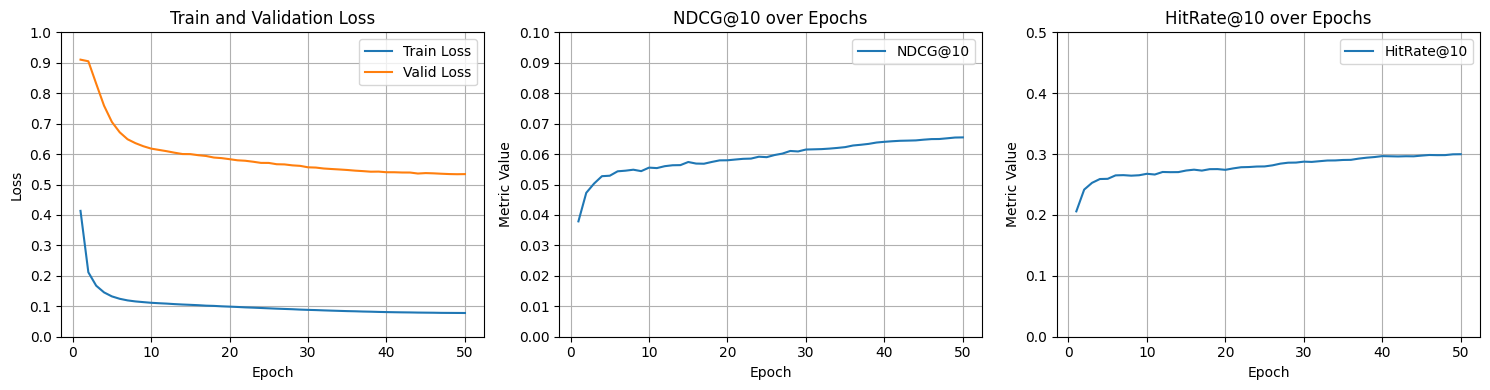

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 hàng, 3 cột

# Create a range of epoch numbers for the x-axis
epochs_range = range(1, len(train_losses) + 1)

# --- Plot 1: Training and Validation Losses ---
axes[0].plot(epochs_range, train_losses, label='Train Loss')
axes[0].plot(epochs_range, valid_losses, label='Valid Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Train and Validation Loss')
axes[0].legend()
axes[0].grid(True)
axes[0].set_ylim(0.0, 1.0)
axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

# --- Plot 2: NDCG@10 over Epochs ---
axes[1].plot(epochs_range, ndcgs_10, label='NDCG@10')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Metric Value')
axes[1].set_title('NDCG@10 over Epochs')
axes[1].legend()
axes[1].grid(True)
axes[1].set_ylim(0.0, 0.1)
axes[1].set_yticks([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])

# --- Plot 3: HitRate@10 over Epochs ---
axes[2].plot(epochs_range, hitrates_10, label='HitRate@10')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Metric Value')
axes[2].set_title('HitRate@10 over Epochs')
axes[2].legend()
axes[2].grid(True)
axes[2].set_ylim(0.0, 0.5)
axes[2].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])

plt.tight_layout()
plt.show()

# **6. Đánh giá khả năng xếp hạng (ranking)**

In [ ]:
model = MF_BPR(
    num_users = num_users,
    num_items = num_games,
    embedding_dim = 64
).to(device)

# Load model with proper device mapping
model.load_state_dict(torch.load(model_dir, map_location=device))
model.to(device)

MF_BPR(
  (user_embedding): Embedding(47274, 64)
  (item_embedding): Embedding(4632, 64)
)

In [ ]:
def create_test_data(dataset_df, train_df, test_df, device, min_unplayed=9):
    # Create game list and mappings
    game_list = sorted(dataset_df["app_id"].unique())
    game2idx = {game_id: idx for idx, game_id in enumerate(game_list)}
    num_games_filtered = len(game_list)

    # Identify warm-start and cold-start users
    train_user_ids = set(train_df["user_id"])
    test_user_ids = set(test_df["user_id"])
    warm_user_ids = sorted(train_user_ids & test_user_ids)
    cold_user_ids = sorted(test_user_ids - train_user_ids)
    all_test_user_ids = warm_user_ids + cold_user_ids
    user2idx = {user_id: idx for idx, user_id in enumerate(all_test_user_ids)}

    # Track interacted games for warm-start users (train)
    user_played_games = defaultdict(set)
    for user_id, game_id in zip(train_df["user_id"], train_df["app_id"]):
        if user_id in user2idx:
            user_played_games[user_id].add(game_id)

    # Track test interactions for all users
    user_test = defaultdict(list)
    for user_id, game_id, label in zip(test_df["user_id"], test_df["app_id"], test_df["is_recommended"]):
        user_test[user_id].append((game_id, label))

    # Initialize tensors
    num_test_users = len(all_test_user_ids)
    test_labels = torch.zeros((num_test_users, num_games_filtered), dtype=torch.float, device=device)
    has_interacted_masks = torch.zeros((num_test_users, num_games_filtered), dtype=torch.bool, device=device)

    # Fill tensors
    for user_id in all_test_user_ids:
        u_idx = user2idx[user_id]
        for game_id, label in user_test[user_id]:
            if game_id in game2idx:
                test_labels[u_idx, game2idx[game_id]] = float(label)
        for game_id in user_played_games.get(user_id, []):
            if game_id in game2idx:
                has_interacted_masks[u_idx, game2idx[game_id]] = True

    # Filter users with too few unplayed games
    good_users = []
    for user_id in all_test_user_ids:
        played = user_played_games.get(user_id, set())
        positives = {g for g, l in user_test[user_id] if l == 1}
        unplayed = set(game_list) - played - positives
        if len(unplayed) >= min_unplayed:
            good_users.append(user_id)

    keep_indices = [user2idx[u] for u in good_users]
    test_labels = test_labels[keep_indices]
    has_interacted_masks = has_interacted_masks[keep_indices]
    warm_users_mask = torch.tensor([u in train_user_ids for u in good_users],
                                   dtype=torch.bool, device=device)
    user_ids_tensor = torch.tensor(good_users, dtype=torch.long, device=device)

    # Create mask for warm-start items
    train_items = set(train_df["app_id"])
    warm_items_mask = torch.tensor([g in train_items for g in game_list],
                                   dtype=torch.bool, device=device)

    return TestData(
        labels=test_labels,
        has_interacted_masks=has_interacted_masks,
        user_ids=user_ids_tensor,
        warm_items_mask=warm_items_mask,
        warm_users_mask=warm_users_mask
    )

test_data = create_test_data(dataset, train_df, test_df, device)

In [ ]:
@torch.no_grad()
def evaluate_ranking_full_corpus(model, test_data, device, k=10, batch_size = 4096):
    print("Evaluating ranking metrics on full corpus...")
    model.eval()

    # Get embeddings
    user_emb = model.user_embedding.weight
    item_emb = model.item_embedding.weight
    emb = torch.cat([user_emb, item_emb])
    num_users = model.num_users
    item_emb = emb[num_users:]

    # Get test data
    test_labels = test_data.labels
    has_interacted_masks = test_data.has_interacted_masks
    user_ids = test_data.user_ids
    warm_items_mask = test_data.warm_items_mask
    warm_users_mask = test_data.warm_users_mask

    # Precompute item embedding parts
    warm_item_emb = item_emb[warm_items_mask]

    # Metrics storage
    all_prec = []
    all_recall = []
    all_ndcg = []
    all_hit = []

    num_test = user_ids.size(0)

    # Process in batches
    for start in tqdm(range(0, num_test, batch_size), desc="Evaluating", leave=False):
        end = min(start + batch_size, num_test)
        batch_idx = slice(start, end)
        batch_user_ids = user_ids[batch_idx]
        batch_warm_mask = warm_users_mask[batch_idx]

        # Initialize scores for all users with zeros
        batch_scores = torch.zeros((end-start, test_labels.size(1)), device=device)

        # Compute scores only for warm-start users
        if batch_warm_mask.any():
            warm_user_indices = torch.where(batch_warm_mask)[0]
            warm_user_ids = batch_user_ids[warm_user_indices]

            # Get embeddings for warm users
            warm_u_emb = emb[warm_user_ids]

            # Compute scores for warm items
            warm_scores = warm_u_emb @ warm_item_emb.T

            # Place warm item scores in the correct positions
            for i, orig_idx in enumerate(warm_user_indices):
                batch_scores[orig_idx, warm_items_mask] = warm_scores[i]

        # Mask scores for already interacted items
        batch_scores = batch_scores.masked_fill(has_interacted_masks[batch_idx], -float('inf'))
        batch_labels = test_labels[batch_idx]

        # Skip users with no positive labels
        valid_users = batch_labels.sum(dim=1) > 0
        if not valid_users.any():
            continue

        batch_scores = batch_scores[valid_users]
        batch_labels = batch_labels[valid_users]

        # Compute metrics
        prec = precision_at_k(batch_scores, batch_labels, k)
        recall = recall_at_k(batch_scores, batch_labels, k)
        ndcg = ndcg_at_k(batch_scores, batch_labels, k)
        hitrate = hitrate_at_k(batch_scores, batch_labels, k)

        all_prec.append(prec)
        all_recall.append(recall)
        all_ndcg.append(ndcg)
        all_hit.append(hitrate)

    # Compute average metrics
    all_prec = torch.cat(all_prec).mean().item() if all_prec else 0.0
    all_recall = torch.cat(all_recall).mean().item() if all_recall else 0.0
    all_ndcg = torch.cat(all_ndcg).mean().item() if all_ndcg else 0.0
    all_hit = torch.cat(all_hit).mean().item() if all_hit else 0.0

    return {
        f"Precision@{k}": all_prec,
        f"Recall@{k}": all_recall,
        f"NDCG@{k}": all_ndcg,
        f"HitRate@{k}": all_hit,
    }

# Đánh giá dựa trên full corpus
full_corpus_result = evaluate_ranking_full_corpus(model, test_data, device)
print("\n--- Full Corpus Ranking Metrics ---")
for metric, value in full_corpus_result.items():
    print(f"{metric}: {value:.4f}")

Evaluating ranking metrics on full corpus...



--- Full Corpus Ranking Metrics ---
Precision@10: 0.0256
Recall@10: 0.0298
NDCG@10: 0.0331
HitRate@10: 0.1917
